# Gaussian Mixture Models (GMM)

In [136]:
import numpy as np
from logpdf_loglikelihood_GAU import logpdf_GAU_ND #for single density of a gaussian component
from scipy.special import logsumexp #for marginalizing the joints to retrieve the GMM log density
from mean_covariance import vrow, vcol, compute_mu_C #for computing the mean and covariance of a Gaussian component

In [137]:
def logpdf_GMM(X, gmm):
    """
    Compute log density of data points X under a Gaussian Mixture Model (GMM).
    Parameters
    -X: matrix of size (D, N) where D is the number of features and N is the number of data points.
    -gmm: list of gaussian components. Each one is a tuple of (weight, mean, covariance).
           weight: scalar
           mean: vector of size (D,)
           covariance: matrix of size (D, D)
        Example: gmm = [(w1, mu1, C1), (w2, mu2, C2), ...]
    Returns
    -logpdf: vector of size (N,) containing the log density of each data point under the GMM.
    """

    #1. create matrix S of shape (K, N), where N = number of samples and K = number of components
    K = len(gmm)  # number of components
    N = X.shape[1]
    S = np.zeros((K, N))

    #iterate over components, for each componente take mean, covariance and compute log density of the Gaussian
    for k in range(K):
        weight, mean, covariance = gmm[k]
        S[k, :] = logpdf_GAU_ND(X, mean, covariance) + np.log(weight)
    
    #these are the log joints, then GMM can be casted as a latent variable model, i.e. we can find the GMM log density marginalizing the joints over the latent variable
    #latent variable if the component/cluster
    logdens = logsumexp(S, axis=0)  #marginalize joints over the components

    return logdens  

we now test the function to compute the GMM log density over a reference dataset using reference GMM parameters:

In [138]:
from GMM_load import load_gmm, save_gmm

In [139]:
#load first GMM
gmm = load_gmm('./GMM_models/GMM_4D_3G_init.json')
example_X = np.load('./Data/GMM_data_4D.npy')

print(f'Shape of example_X: {example_X.shape}')

GMM_ll = logpdf_GMM(example_X, gmm)
print(f'GMM log likelihood shape: {GMM_ll.shape}')

#compare
GMM_ll_solution = np.load('./GMM_models/ll/GMM_4D_3G_init_ll.npy')

#check if the log likelihoods are equal
if np.allclose(GMM_ll, GMM_ll_solution):
    print("The computed log likelihoods match the solution.")

Shape of example_X: (4, 1000)
GMM log likelihood shape: (1000,)
The computed log likelihoods match the solution.


In [140]:
#chek with 1-D Data
gmm_1D = load_gmm('./GMM_models/GMM_1D_3G_init.json')
example_X_1D = np.load('./Data/GMM_data_1D.npy')
print(f'Shape of example_X_1D: {example_X_1D.shape}')
GMM_ll_1D = logpdf_GMM(example_X_1D, gmm_1D)
print(f'GMM log likelihood shape for 1D data: {GMM_ll_1D.shape}')

#compare with 1D solution
GMM_ll_1D_solution = np.load('./GMM_models/ll/GMM_1D_3G_init_ll.npy')
#check if the log likelihoods are equal
if np.allclose(GMM_ll_1D, GMM_ll_1D_solution):
    print("The computed log likelihoods for 1D data match the solution.")

Shape of example_X_1D: (1, 4000)
GMM log likelihood shape for 1D data: (4000,)
The computed log likelihoods for 1D data match the solution.


# GMM Estimation: E-M Algorithm

1) **E-step**: here we have to minimize the KL divergence, so the ELBO gets higher and equals to objective function of GMM. In practice, in order to make the KL divergence become equal to zero, its minimum, we are required to compute the responsibilities, so the cluster posteriors. So, we compute the **auxiliary function**:
    $$
    \text{AUX}(\theta, \theta_t) = \mathbb{E}_{C_1, ..., C_M \mid \mathbf{X}_1 = \mathbf{x}_1, ...., \mathbf{X}_N = \mathbf{x}_N, \theta_t} \left[ \log f_{\mathbf{X}_1, ..., \mathbf{X}_N, C_1, ..., C_N}(\mathbf{x}_1, ..., \mathbf{x}_N, c_1, ..., c_N \mid \theta_t)\right]
    $$
    Exploiting the *i.i.d* assumption for our samples, and the linearity property of the expectation operator (i.e. an expectation over a sum is equal to the sum of all the single expectations):
    $$
    \text{AUX}(\theta, \theta_t) = \sum_{i = 1}^N \mathbb{E}_{C_1, ..., C_M \mid \mathbf{X}_1 = \mathbf{x}_1, ...., \mathbf{X}_N = \mathbf{x}_N, \theta_t} \left[ \log f_{\mathbf{X}_i, C_i}(\mathbf{x}_i, c_i \mid \theta_t)\right]
    $$
    Then we can observe that, since in the expectations we just have the log-joint for the i-th samples, these expectations just depends on the posteriors of the i-th samples:
    $$
    \text{AUX}(\theta, \theta_t) = \sum_{i = 1}^N \mathbb{E}_{C_i \mid \mathbf{X}_i = \mathbf{x}_i, \theta_t} \left[ \log f_{\mathbf{X}_i, C_i}(\mathbf{x}_i, c_i \mid \theta_t)\right]
    $$
    Then, computing the responsibilities, we can write the values of these expectations as:
    $$
    \text{AUX}(\theta, \theta_t) = \sum_{i = 1}^N \sum_{c = 1}^{K} \gamma_{c, i} \left[ \log \mathcal{N}(\mathbf{x}_i \mid \mu_c, \mathbf{\Sigma}_c) + \log w_c\right]
    $$
    So, $\text{AUX}(\theta, \theta_t)$ depends on the cluster posteriors, which we compute in this step like this:
    $$
    \gamma_{c, i} = f_{C \mid \mathbf{X}}(c \mid \mathbf{x}_i, \mathbf{\theta}_t) = \frac{\mathcal{N}(\mathbf{x}_i \mid \mu_c, \mathbf{\Sigma}_c) wc}{\sum_{c' = 1}^K \mathcal{N}(\mathbf{x}_i \mid \mu_c', \mathbf{\Sigma}_c') wc'}
    $$

2) **M-step**: in this step we use the cluster labels inferred in the first step, to estimate a new set of model parameters. In practice, we optimize the auxiliary function $\text{AUX}(\theta, \theta_t)$ wrt $\theta = \left[ \mathbf{M}, \mathbf{S}, \mathbf{w}\right]$ and $\sum_{i = 1}^K w_c = 1$, following a ML approach, and we find:
    $$
    \mu_c^{t+1} = \frac{\sum_{i = 1}^N \gamma_{c, i} \mathbf{x}_i}{\sum_{i = 1}^N \gamma_{c, i}}
    $$
    $$
    \mathbf{\Sigma}_c^{t+1} = \frac{\sum_{i = 1}^N \gamma_{c, i} \left( \mathbf{x}_i - \mu_c\right) \left( \mathbf{x}_i - \mu_c\right)^T}{\sum_{i = 1}^N \gamma_{c, i}}
    $$
    $$
    w_c^{t+1} = \frac{\sum_{i = 1}^N \gamma_{c, i}}{\sum_{c' = 1}^K \sum_{i = 1}^N \gamma_{c', i}}
    $$
    Here we can call $N_c = \sum_{i = 1}^N \gamma_{c, i}$ and $N = \sum_{c' = 1}^K \sum_{i = 1}^N \gamma_{c', i}$. Note that when camputing these parameters for cluser $c$ we **always sum all the fractions of the points in the dataset**, thus respecting the **soft margin assignments** approach. <br>
    When programming the algorithm, we can build and reuse for all the three estimates these zero, first and second order statistics:
    $$
    Z_c = \sum_{i = 1}^N \gamma_{c, i} \qquad
    
    \mathbf{F}_c = \sum_{i = 1}^N \gamma_{c, i} \mathbf{x}_i \qquad
    
    \mathbf{S}_c = \sum_{i = 1}^N \gamma_{c, i} \mathbf{x}_i \mathbf{x}_i^T
    $$
    and rewrite the new three estimates for cluster $c$ this way:
    $$
    \mu_c^{t+1} = \frac{\mathbf{F}_c}{Z_c}
    $$
    $$
    \mathbf{\Sigma}_c^{t+1} = \frac{\mathbf{S}_c}{Z_c} - \mu_c^{(t+1)} {\mu_c^{(t+1)}}^T
    $$
    $$
    w_c^{t+1} = \frac{Z_c}{N}
    $$

E-M in practice:

In [141]:
def GMM_EM_iteration(X, gmm_start):
   """
      One single iteration of the EM algorithm for Gaussian Mixture Models (GMM).
      Parameters
      -X: matrix of size (D, N) where D is the number of features and N is the number of data points.
      -gmm_start: list of starter GMM components. Can be obtained with either K-Means or LGB Algorithm.
               Each one is a tuple of (weight, mean, covariance).
               weight: scalar
               mean: vector of size (D,)
               covariance: matrix of size (D, D)
      -threshold_stop: threshold for stopping the EM algorithm. If the change in log likelihood is less than this value, stop.
      Returns
      -gmm: list of gaussian components. Each one is a tuple of (weight, mean, covariance).
            weight: scalar
            mean: vector of size (D,)
            covariance: matrix of size (D, D)
    """
    
   #1. E-STEP: compute responsibilities
   #create matrix S of shape (K, N), where N = number of samples and K = number of components
   K = len(gmm_start)  # number of components
   N = X.shape[1]
   S = np.zeros((K, N))

   #iterate over components, for each componente take mean, covariance and compute log density of the Gaussian
   for k in range(K):
      weight, mean, covariance = gmm_start[k]
      S[k, :] = logpdf_GAU_ND(X, mean, covariance) + np.log(weight)


   #for each sample, marginalize the log-joints over the components to get the log-marginal
   logdens = logsumexp(S, axis=0)  #vector of size (N,)

   #compute log-posteriors by removing log-marginal from the log-joints
   log_posteriors = S - logdens   #(K, N) - (N,) -> broadcasting -> (K, N) - (N,N) = (K, N) thanks to broadcasting

   #compute responsibilities, so cluster posteriors, by exponentiating the log-posteriors
   responsibilities = np.exp(log_posteriors) #(K, N)


   #2. M-STEP: estimate new GMM parameters
   gmm = []
   #compute zero, first, and second order statistics from the responsibilities of each cluster
   #for each cluster k, do:
   for k in range(K):
      gamma = responsibilities[k, :]
      Z_gamma = np.sum(gamma) #zero order
      F_gamma = vcol(np.sum(vrow(gamma) * X, axis = 1)) #first order
      S_gamma = (vrow(gamma) * X) @ X.T #second order, (D, N) @ (N, D) = (D, D)

      #ESTIMATE NEW PARAMS for the cluster k
      mu_k_new = F_gamma / Z_gamma  #col vector (D, 1)
      cov_k_new = S_gamma / Z_gamma - vcol(mu_k_new) @ vrow(mu_k_new)  #covariance matrix, (D, D)
      weight_k_new = Z_gamma / N #n = sum of reponsibilities for each sample for each cluster k = total number of samples, since responsibilities of each sample sum to 1 being fractions
      gmm.append((weight_k_new, mu_k_new, cov_k_new))  #append new params for the cluster k

   return gmm  #return the new GMM parameters after one EM iteration



def train_GMM_EM(X, gmm_start, threshold_stop=1e-6, max_iter=1000):
   """
   EM algorithm for Gaussian Mixture Models (GMM). 
   Parameters
   -X: matrix of size (D, N) where D is the number of features and N is the number of data points.
   -gmm_start: list of starter GMM components. Can be obtained with either K-Means or LGB Algorithm.
            Each one is a tuple of (weight, mean, covariance).
            weight: scalar
            mean: vector of size (D,)
            covariance: matrix of size (D, D)
   -threshold_stop: threshold for stopping the EM algorithm. If the change in log likelihood is less than this value, stop.
   -max_iter: maximum number of iterations for the EM algorithm.
   Returns
   -gmm: list of gaussian components. Each one is a tuple of (weight, mean, covariance).
            weight: scalar
            mean: vector of size (D,)
            covariance: matrix of size (D, D)
   """

   gmm_old = gmm_start.copy()  
   num_iters = 0
   while True:
      #compute the log likelihood with old GMM params
      GMM_ll_old = logpdf_GMM(X, gmm_old).mean()  

      #run 1 iter of EM
      gmm_new = GMM_EM_iteration(X, gmm_old)

      #compute new log likelihood
      GMM_ll_new = logpdf_GMM(X, gmm_new).mean()

      #for sure GMM_ll_new >= GMM_ll_old
      #stop if GMM_ll_new - GMM_ll_old < threshold_stop
      if GMM_ll_old > GMM_ll_new:
         print("Warning: mean GMM log likelihood decreased. This is unexpected.")
         print(f"GMM_ll_old (mean): {GMM_ll_old}, GMM_ll_new (mean): {GMM_ll_new}")
         
      if GMM_ll_new - GMM_ll_old < threshold_stop:
         break

      num_iters += 1
      if num_iters >= max_iter:
         print(f"Reached maximum number of iterations: {max_iter}. Stopping EM.")
         break

      #update old GMM params
      gmm_old = gmm_new.copy()


   return gmm_new, GMM_ll_new  #return the last GMM parameters after EM iterations, plus the final log likelihood


Let's apply the E-M Algorithm to the example data, using example initial params:

In [142]:
example_X = np.load('./Data/GMM_data_4D.npy')
gmm_start = load_gmm('./GMM_models/GMM_4D_3G_init.json')
threshold_stop = 1e-6
gmm_final, _ = train_GMM_EM(example_X, gmm_start, threshold_stop=threshold_stop)


#compare with the solution
gmm_EM_solution = load_gmm('./GMM_models/GMM_4D_3G_EM.json')

#check if the GMM parameters are equal
if all(np.isclose(gmm_final[k][0], gmm_EM_solution[k][0]) and np.allclose(gmm_final[k][1], gmm_EM_solution[k][1]) and np.allclose(gmm_final[k][2], gmm_EM_solution[k][2]) for k in range(len(gmm_final))):
    print("The computed GMM parameters match the solution.")

The computed GMM parameters match the solution.


# LBG + E-M

In [143]:
def LBG(gmmToSplit, alpha):
    """
    Apply Linde-Buzo-Gray (LBG) algorithm to split a GMM component into two.
    This atomically splits a 1-Component GMM (i.e. a single Gaussian) into two components (i.e. two Gaussians).
    Parameters
    -gmmToSplit: a GMM with a single component, i.e. a tuple of (weight, mean, covariance).
                 weight: scalar
                 mean: vector of size (D,)
                 covariance: matrix of size (D, D)
    -alpha: scalar, the factor by which to scale the displacement vector. It dictates how far the two new components will be displaced from the original component.
    """

    #cov matrices are left like this
    weights_new = gmmToSplit[0] / 2  #split the weight in half

    #to separate the two components, we displace the mean of the original component along the direction of maximum variance
    #so in practice, we compute two means, which are the top of the Gaussian bell, and decide how far apart they have to be from each other
    #alpha is a scaling factor that determines how far apart the two new components will be from the original component
    #compute displacement vector by taking the leading eigevctor of the covariance matrix
    #in practce, we are displacing the 2 components along the direction of maximum variance
    #the step we use is the square root of the leading eigenvalue, which is the standard deviation along the leading eigenvector
    U, s, Vh = np.linalg.svd(gmmToSplit[2])  #SVD to get the leading eigenvector
    displacement_vector = vcol(U[:, 0] * np.sqrt(s[0]) * alpha)  #leading eigenvector scaled by the square root of the leading eigenvalue and alpha

    return [
        (weights_new, gmmToSplit[1] - displacement_vector, gmmToSplit[2]),  #first component
        (weights_new, gmmToSplit[1] + displacement_vector, gmmToSplit[2])   #second component
    ]  #return the two new components as a list of tuples

In [144]:
def train_GMM_EM_LBG(X, targetNumberComponents, threshold_stop=1e-6, alpha=0.1):
    """
    Train a GMM using Expectation-Maximization algorithm, with a target number of components using the Linde-Buzo-Gray (LBG) algorithm.
    Parameters
    -X: matrix of size (D, N) where D is the number of features and N is the number of data points.
    -targetNumberComponents: target number of Gaussian components to reach in the GMM. It has to be an even number, grater or equal than 2
    -threshold_stop: threshold for stopping the EM algorithm. If the change in log likelihood is less than this value, stop.
    -alpha: scalar, the factor by which to scale the displacement vector in the LBG algorithm.
            It dictates how far the two new components will be displaced from the original component, along the direction of maximum variance.
    Returns
    -gmm: list of gaussian components. Each one is a tuple of (weight, mean, covariance).
          weight: scalar
          mean: vector of size (D,)
          covariance: matrix of size (D, D)
    """
    #check if targetNumberComponents is even, and greater than or equal to 2
    if targetNumberComponents < 2 or targetNumberComponents % 2 != 0:
        raise ValueError("targetNumberComponents must be an even number greater than or equal to 2.")
    
    currentNumberComponents = 1
    GMM_ll_new = 0 #final log likelihood to be returned

    #start with a 1-component GMM, i.e. the initial GMM is a single Gaussian
    #its params, following a ML approach, are the empirical mean and empirical covariance matrix 
    mu, c = compute_mu_C(X)
    gmm_old = [(1.0, mu, c)]  #initial GMM with a single component, weight = 1.0, mean = mu, covariance = c

    while currentNumberComponents < targetNumberComponents:

        #phase 1: split components, go from G to 2G components
        gmm_new = []
        for k in range(currentNumberComponents):
            _2GComponents = LBG(gmm_old[k], alpha)  #split each component into two with LBG
            gmm_new.append(_2GComponents[0])  
            gmm_new.append(_2GComponents[1])
            currentNumberComponents += 1 #from 1 we split into 2, so we increase the number of components by 1 every time we split a component

        

        #phase2: use the 2G components as initial GMM for EM and let it converge
        gmm_old, GMM_ll_new = train_GMM_EM(X, gmm_new, threshold_stop=threshold_stop)


    return gmm_old, GMM_ll_new  #return the final GMM parameters after EM iterations, plus the final log likelihood

    


Let's test EM+LBG with sample data:

In [145]:
example_X = np.load('./Data/GMM_data_4D.npy')
print(f'Shape of example_X: {example_X.shape}')
gmm_em_lbg, final_ll = train_GMM_EM_LBG(X=example_X, targetNumberComponents=example_X.shape[0], threshold_stop=1e-6, alpha=0.1)

#check if the GMM parameters are equal to the solution
gmm_EM_LBG_solution = load_gmm('./GMM_models/GMM_4D_4G_EM_LBG.json')

#check if the GMM parameters are equal
if all(np.isclose(gmm_em_lbg[k][0], gmm_EM_LBG_solution[k][0]) and np.allclose(gmm_em_lbg[k][1], gmm_EM_LBG_solution[k][1]) and np.allclose(gmm_em_lbg[k][2], gmm_EM_LBG_solution[k][2]) for k in range(len(gmm_em_lbg))):
    print("The computed GMM parameters after LBG match the solution.")

Shape of example_X: (4, 1000)
The computed GMM parameters after LBG match the solution.


Let's try it with a 1 dimensional dataset, and let's plot the estimated GMM density:


In [146]:
one_dimensional_example_X = np.load('./Data/GMM_data_1D.npy')
print(f'Shape of one_dimensional_example_X: {one_dimensional_example_X.shape}')
gmm_em_lbg_1D, final_ll_1D = train_GMM_EM_LBG(X=one_dimensional_example_X, targetNumberComponents=4, threshold_stop=1e-6, alpha=0.1)

Shape of one_dimensional_example_X: (1, 4000)


In [147]:
len(gmm_em_lbg_1D)

4

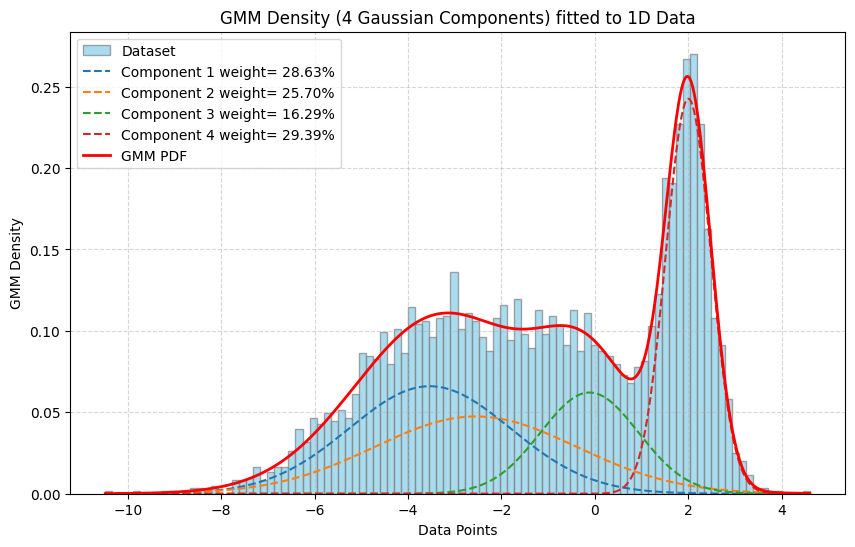

In [148]:
import matplotlib.pyplot as plt

def plot_GMM_1D(X_data, gmm):
    """
    Plots the Gaussian Mixture Model (GMM) density function over the histogram of the original data.

    Parameters:
    - X_data: array-like, shape (N,) or (N, 1)
    - gmm: list of tuples, where each tuple represents a Gaussian component in the GMM.
    """
    plt.figure(figsize=(10, 6))
    
    plt.hist(X_data.ravel(), bins=100, density=True, label='Dataset', alpha=0.7, color='skyblue', edgecolor='grey')
    
    x_plot = np.linspace(X_data.min(), X_data.max(), 1000)
    
    #we have to reshape x_plot to be a row vector, so from (1000,) to (1, 1000)
    x_plot_reshaped = vrow(x_plot)

    #compute the log density of the GMM over the x_plot, and then exponentiate it to get the PDF
    log_pdf_gmm = logpdf_GMM(x_plot_reshaped, gmm)
    pdf_gmm = np.exp(log_pdf_gmm)
    
    numberGaussianComponents = len(gmm)

    #first plot the individual Gaussian components with their weight
    for i, component in enumerate(gmm):
        weight, mean, covariance = component
        
        
        log_pdf_component = logpdf_GAU_ND(x_plot_reshaped, mean, covariance) + np.log(weight)
        pdf_component = np.exp(log_pdf_component)
        
        plt.plot(x_plot, pdf_component, linestyle='--', linewidth=1.5, label=f'Component {i+1} weight={weight * 100: .2f}%')

    #then plot the GMM density, so the weighted sum of the individual components
    plt.plot(x_plot, pdf_gmm, color='red', linewidth=2, label='GMM PDF')
    
    plt.title(f'GMM Density ({numberGaussianComponents} Gaussian Components) fitted to 1D Data')
    plt.xlabel('Data Points')
    plt.ylabel('GMM Density')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


plot_GMM_1D(one_dimensional_example_X, gmm_em_lbg_1D)

## Constraining the eigenvalues of the covariance matrices

GMM estimation for more than 1 component using the ML approach is an **ill-posed** problem, because the GMM log-likelihood is not bounded above for $M \ge 2$. Indeed, we can have arbitrarily high log-likelihood by centering one component at one of the N samples, and letting the corresponding covariance matrix shrink towards zero. To avoid these kind of degenerate solutions, we can constrain the minimum values of the eigenvalues of the covariance matrices.

A possible solution consists in **constraining the eigenvalues of the covariance matrices to be larger or equal to a lower bound $\psi > 0$**. It's possible to show that the solution can be obtained by modifying the output of the M-step in the previous section. In particular, after we have computed $\Sigma_{g_{t+1}}$, we can compute its SVD:

$$U_g, S_g, U_g^T = \Sigma_{g_{t+1}}$$

where $S_g$ is a diagonal matrix of singular values, and replace the estimated covariance with

$$\Sigma_{g_{t+1}} = U_g S'_g U_g^T, \quad S'_{g_{ii}} = \max(\psi, S_{g_{ii}})$$

where $S'_{g_{ii}}$ is the $i$-th element of the diagonal of matrix $S'_g$.

In [149]:
def smooth_Covariance_Matrix(c, psiEig):
    U, s, _ = np.linalg.svd(c)
    s[s< psiEig] = psiEig
    return np.dot(U, vcol(s)*U.T)

def GMM_EM_iteration(X, gmm_start, psiEig=None):
   """
      One single iteration of the EM algorithm for Gaussian Mixture Models (GMM).
      Parameters
      -X: matrix of size (D, N) where D is the number of features and N is the number of data points.
      -gmm_start: list of starter GMM components. Can be obtained with either K-Means or LGB Algorithm.
               Each one is a tuple of (weight, mean, covariance).
               weight: scalar
               mean: vector of size (D,)
               covariance: matrix of size (D, D)
      -threshold_stop: threshold for stopping the EM algorithm. If the change in log likelihood is less than this value, stop.
      Returns
      -gmm: list of gaussian components. Each one is a tuple of (weight, mean, covariance).
            weight: scalar
            mean: vector of size (D,)
            covariance: matrix of size (D, D)
    """
    
   #1. E-STEP: compute responsibilities
   #create matrix S of shape (K, N), where N = number of samples and K = number of components
   K = len(gmm_start)  # number of components
   N = X.shape[1]
   S = np.zeros((K, N))

   #iterate over components, for each componente take mean, covariance and compute log density of the Gaussian
   for k in range(K):
      weight, mean, covariance = gmm_start[k]
      S[k, :] = logpdf_GAU_ND(X, mean, covariance) + np.log(weight)


   #for each sample, marginalize the log-joints over the components to get the log-marginal
   logdens = logsumexp(S, axis=0)  #vector of size (N,)

   #compute log-posteriors by removing log-marginal from the log-joints
   log_posteriors = S - logdens   #(K, N) - (N,) -> broadcasting -> (K, N) - (N,N) = (K, N) thanks to broadcasting

   #compute responsibilities, so cluster posteriors, by exponentiating the log-posteriors
   responsibilities = np.exp(log_posteriors) #(K, N)


   #2. M-STEP: estimate new GMM parameters
   gmm = []
   #compute zero, first, and second order statistics from the responsibilities of each cluster
   #for each cluster k, do:
   for k in range(K):
      gamma = responsibilities[k, :]
      Z_gamma = np.sum(gamma) #zero order
      F_gamma = vcol(np.sum(vrow(gamma) * X, axis = 1)) #first order
      S_gamma = (vrow(gamma) * X) @ X.T #second order, (D, N) @ (N, D) = (D, D)

      #ESTIMATE NEW PARAMS for the cluster k
      mu_k_new = F_gamma / Z_gamma  #col vector (D, 1)
      cov_k_new = S_gamma / Z_gamma - vcol(mu_k_new) @ vrow(mu_k_new)  #covariance matrix, (D, D)
      #if psiEig is provided, we have to contrain te eigvalues of the covariance matrix
      if psiEig is not None: cov_k_new = smooth_Covariance_Matrix(cov_k_new, psiEig)
      weight_k_new = Z_gamma / N #n = sum of reponsibilities for each sample for each cluster k = total number of samples, since responsibilities of each sample sum to 1 being fractions
      gmm.append((weight_k_new, mu_k_new, cov_k_new))  #append new params for the cluster k

   return gmm  #return the new GMM parameters after one EM iteration



def train_GMM_EM(X, gmm_start, threshold_stop=1e-6, psiEig=None, max_iter=1000):
   """
   EM algorithm for Gaussian Mixture Models (GMM). 
   Parameters
   -X: matrix of size (D, N) where D is the number of features and N is the number of data points.
   -gmm_start: list of starter GMM components. Can be obtained with either K-Means or LGB Algorithm.
            Each one is a tuple of (weight, mean, covariance).
            weight: scalar
            mean: vector of size (D,)
            covariance: matrix of size (D, D)
   -threshold_stop: threshold for stopping the EM algorithm. If the change in log likelihood is less than this value, stop.
   -max_iter: maximum number of iterations for the EM algorithm.
   Returns
   -gmm: list of gaussian components. Each one is a tuple of (weight, mean, covariance).
            weight: scalar
            mean: vector of size (D,)
            covariance: matrix of size (D, D)
   """

   gmm_old = gmm_start.copy()  
   num_iters = 0
   while True:
      #compute the log likelihood with old GMM params
      GMM_ll_old = logpdf_GMM(X, gmm_old).mean()  

      #run 1 iter of EM
      gmm_new = GMM_EM_iteration(X, gmm_old, psiEig=psiEig)

      #compute new log likelihood
      GMM_ll_new = logpdf_GMM(X, gmm_new).mean()

      #for sure GMM_ll_new >= GMM_ll_old
      #stop if GMM_ll_new - GMM_ll_old < threshold_stop
      if GMM_ll_old > GMM_ll_new:
         print("Warning: mean GMM log likelihood decreased. This is unexpected.")
         print(f"GMM_ll_old (mean): {GMM_ll_old}, GMM_ll_new (mean): {GMM_ll_new}")
         
      if GMM_ll_new - GMM_ll_old < threshold_stop:
         break

      num_iters += 1
      if num_iters >= max_iter:
         print(f"Reached maximum number of iterations: {max_iter}. Stopping EM.")
         break

      #update old GMM params
      gmm_old = gmm_new.copy()


   return gmm_new, GMM_ll_new  #return the last GMM parameters after EM iterations, plus the final log likelihood


def LBG(gmmToSplit, alpha):
    """
    Apply Linde-Buzo-Gray (LBG) algorithm to split a GMM component into two.
    This atomically splits a 1-Component GMM (i.e. a single Gaussian) into two components (i.e. two Gaussians).
    Parameters
    -gmmToSplit: a GMM with a single component, i.e. a tuple of (weight, mean, covariance).
                 weight: scalar
                 mean: vector of size (D,)
                 covariance: matrix of size (D, D)
    -alpha: scalar, the factor by which to scale the displacement vector. It dictates how far the two new components will be displaced from the original component.
    """

    #cov matrices are left like this
    weights_new = gmmToSplit[0] / 2  #split the weight in half

    #to separate the two components, we displace the mean of the original component along the direction of maximum variance
    #so in practice, we compute two means, which are the top of the Gaussian bell, and decide how far apart they have to be from each other
    #alpha is a scaling factor that determines how far apart the two new components will be from the original component
    #compute displacement vector by taking the leading eigevctor of the covariance matrix
    #in practce, we are displacing the 2 components along the direction of maximum variance
    #the step we use is the square root of the leading eigenvalue, which is the standard deviation along the leading eigenvector
    U, s, Vh = np.linalg.svd(gmmToSplit[2])  #SVD to get the leading eigenvector
    displacement_vector = vcol(U[:, 0] * np.sqrt(s[0]) * alpha)  #leading eigenvector scaled by the square root of the leading eigenvalue and alpha

    return [
        (weights_new, gmmToSplit[1] - displacement_vector, gmmToSplit[2]),  #first component
        (weights_new, gmmToSplit[1] + displacement_vector, gmmToSplit[2])   #second component
    ]  #return the two new components as a list of tuples

def train_GMM_EM_LBG(X, targetNumberComponents, threshold_stop=1e-6, alpha=0.1, psiEig=None):
    """
    Train a GMM using Expectation-Maximization algorithm, with a target number of components using the Linde-Buzo-Gray (LBG) algorithm.
    Parameters
    - X: matrix of size (D, N) where D is the number of features and N is the number of data points.
    - targetNumberComponents: target number of Gaussian components to reach in the GMM. It has to be either 1 or an even number, grater or equal than 2
    - threshold_stop: threshold for stopping the EM algorithm. If the change in log likelihood is less than this value, stop.
    - alpha: scalar, the factor by which to scale the displacement vector in the LBG algorithm.
            It dictates how far the two new components will be displaced from the original component, along the direction of maximum variance.
    - psiEig: optional, lowere bound > 0, to conntrain the eigenvalues of the covariance matrices of the GMM components to be > psiEig. This way, we won'threshold_stop
    have unboujnded GMM objective function for >=2 components (the GMM objective optimization in fact is an ill-posed problem, so we need to constrain the covariance matrices).
    Returns
    -gmm: list of gaussian components. Each one is a tuple of (weight, mean, covariance).
          weight: scalar
          mean: vector of size (D,)
          covariance: matrix of size (D, D)
    """
    #check if targetNumberComponents is either 1 or even, and greater than or equal to 2
    if targetNumberComponents != 1 and (targetNumberComponents < 2 or targetNumberComponents % 2 != 0):
        raise ValueError("targetNumberComponents must be either 1 or an even number greater than or equal to 2.")
    
    currentNumberComponents = 1
    GMM_ll_new = 0 #final log likelihood to be returned

    #start with a 1-component GMM, i.e. the initial GMM is a single Gaussian
    #its params, following a ML approach, are the empirical mean and empirical covariance matrix 
    mu, c = compute_mu_C(X)

    #if psiEig is provided, we have to contrain te eigvalues ALSO OF THE FIRST, STARTING COMPONENT
    if psiEig is not None:
        c = smooth_Covariance_Matrix(c, psiEig)  #contrain the covariance matrix eigenvalues to be > psiEig

    gmm_old = [(1.0, mu, c)]  #initial GMM with a single component, weight = 1.0, mean = mu, covariance = c

    while currentNumberComponents < targetNumberComponents:

        #phase 1: split components, go from G to 2G components
        gmm_new = []
        for k in range(currentNumberComponents):
            _2GComponents = LBG(gmm_old[k], alpha)  #split each component into two with LBG
            gmm_new.append(_2GComponents[0])  
            gmm_new.append(_2GComponents[1])
            currentNumberComponents += 1 #from 1 we split into 2, so we increase the number of components by 1 every time we split a component

        

        #phase2: use the 2G components as initial GMM for EM and let it converge
        gmm_old, GMM_ll_new = train_GMM_EM(X, gmm_new, threshold_stop=threshold_stop, psiEig=psiEig)


    return gmm_old, GMM_ll_new  #return the final GMM parameters after EM iterations, plus the final log likelihood

    


In [150]:
#train GMM usinng EM+LBG and contrain eigenvalues of covariance matrices
X = np.load('Data/GMM_data_4D.npy')
gmm_contrained = train_GMM_EM_LBG(X, 4, psiEig=0.01)

# GMM for classification

GMMs can be used for classification in a similar way as we did for the MVG classifier. In particular,
we can train a GMM $GMM(\mathbf{M}_c,\mathbf{S}_c, w_c)$ for each class of thedataset, then model the class conditional distributions as GMM:
$$
f_{\mathbf{X} \mid C, \theta }(\mathbf{x} \mid c, \theta) \sim GMM(\mathbf{M}_c,\mathbf{S}_c, w_c)
$$
$$
f_{\mathbf{X} \mid C, \theta }(\mathbf{x} \mid c, \theta) = \sum_{k = 1}^{K_c} w_k \mathcal{N}(\mathbf{x} \mid \mu_{k, c}, \mathbf{\Sigma}_{k, c})
$$
Then we can compute the class posteriors using Bayes' rule:
$$
P(C = c \mid \mathbf{X} = \mathbf{x}) = \frac{P(C = c) \sum_{k = 1}^{K_c} w_k \mathcal{N}(\mathbf{x} \mid \mu_{k, c}, \mathbf{\Sigma}_{k, c})}{\sum_{c'} P(C = c') \sum_{k = 1}^{K_c} w_k \mathcal{N}(\mathbf{x} \mid \mu_{k, c'}, \mathbf{\Sigma}_{k, c'})}
$$
And, when solving multiclass problem, resort to the optimal Bayes decision for each class, whereas when resolving binary problems, compute the log posterior ratio.

In [151]:
from load_dataset import loadDataSet
from train_validation_split import splitTrainingValidation
from decisionModelsEvaluation import computeEmpiricalBayesRisk_Normalized, computeMinEmpiricalBayesRisk_Normalized
irisPath = "./Data/iris.csv"

D, L = loadDataSet(irisPath, 4)

print(f"Shape of D: {D.shape}, Shape of L: {L.shape}")

(DTR, LTR), (DVAL, LVAL) = splitTrainingValidation(2.0/3.0, D, L)

print(f"Shape of DTR: {DTR.shape}, Shape of LTR: {LTR.shape}")
print(f"Shape of DVAL: {DVAL.shape}, Shape of LVAL: {LVAL.shape}")


#we try different number of components, so we can see how the GMM performs with different number of components

for k in [1, 2, 4, 8, 16]:
    #we model each one of the 3 classes with a GMM, so we have 3 GMMs
    gmm0, ll0 = train_GMM_EM_LBG(DTR[:, LTR == 0], targetNumberComponents=k, threshold_stop=1e-6, alpha=0.1, psiEig=0.01)
    gmm1, ll1 = train_GMM_EM_LBG(DTR[:, LTR == 1], targetNumberComponents=k, threshold_stop=1e-6, alpha=0.1, psiEig=0.01)
    gmm2, ll2 = train_GMM_EM_LBG(DTR[:, LTR == 2], targetNumberComponents=k, threshold_stop=1e-6, alpha=0.1, psiEig=0.01)

    
    #we crate a score matrix of the 3 class conditional densities, which we model as GMMs
    SVAL = np.zeros((3, DVAL.shape[1]))  #score matrix of shape (3, N), where N is the number of validation samples
    #compute the score for each class
    SVAL[0, :] = logpdf_GMM(DVAL, gmm0)  #score for class 0
    SVAL[1, :] = logpdf_GMM(DVAL, gmm1)  #score for class 1
    SVAL[2, :] = logpdf_GMM(DVAL, gmm2)  #score for class 2

    #now compute log posterirs using Bayes' rule
    #we assume uniform priors, each one of 1/3
    priors = np.ones((3, DVAL.shape[1])) / 3.0

    log_posteriors = SVAL + np.log(priors)  #log posteriors of shape (3, N)

    #multiclass problem  -> choose optimal bayes decision, i.e. choose the class with the highest log posterior
    PVAL = np.argmax(log_posteriors, axis=0)  #predicted labels for the validation set


    #error rate
    error_rate = np.mean(PVAL != LVAL)  #error rate is the mean of the misclassified samples
    print(f"Number of components: {k}, Error rate: {error_rate * 100:.2f}%")


Shape of D: (4, 150), Shape of L: (150,)
Shape of DTR: (4, 100), Shape of LTR: (100,)
Shape of DVAL: (4, 50), Shape of LVAL: (50,)
Number of components: 1, Error rate: 4.00%
Number of components: 2, Error rate: 4.00%
Number of components: 4, Error rate: 4.00%
Number of components: 8, Error rate: 4.00%
Number of components: 16, Error rate: 4.00%


As we already said, for binary tasks we can also compute the log posterior ratio $s(\mathbf{x}_t)$, from which we can derive the log likelihood ratio $\text{llr}(\mathbf{x}_t)$ and compare it with the prior log odds as threshold Then, we can compute the $\text{DCF}$ and $\text{min DCF}$ and see the goodness of the models and their misscalibration. We use an equivalent prior $\pi_T = 0.5$:

In [152]:
#load binary dataset
D, L = np.load('Data/ext_data_binary.npy'), np.load('Data/ext_data_binary_labels.npy')

print(f"Shape of D: {D.shape}, Shape of L: {L.shape}")

(DTR, LTR), (DVAL, LVAL) = splitTrainingValidation(2.0/3.0, D, L)
print(f"Shape of DTR: {DTR.shape}, Shape of LTR: {LTR.shape}")
print(f"Shape of DVAL: {DVAL.shape}, Shape of LVAL: {LVAL.shape}")

Shape of D: (4, 600), Shape of L: (600,)
Shape of DTR: (4, 400), Shape of LTR: (400,)
Shape of DVAL: (4, 200), Shape of LVAL: (200,)


In [ ]:
def plot_contours(ax, data_class, gmm, title, features_to_plot=(0, 1)):
    """
    Helper function to draw a scatter plot of data and overlay GMM contour plots.
    
    Parameters:
    - ax: Matplotlib axis object to draw on.
    - data_class: The data for a single class, shape (D, N).
    - gmm: The trained GMM model for that class.
    - title: The title for the subplot.
    - features_to_plot: A tuple of two indices for the features to use as x and y axes.
    """
    D = data_class.shape[0]
    feat_x, feat_y = features_to_plot
    
    # 1. Scatter plot of the real data points for the two chosen features
    ax.scatter(data_class[feat_x, :], data_class[feat_y, :], alpha=0.3, s=10, label='Samples')
    
    # 2. Create a 2D grid for evaluation
    x_min, x_max = data_class[feat_x, :].min() - 1, data_class[feat_x, :].max() + 1
    y_min, y_max = data_class[feat_y, :].min() - 1, data_class[feat_y, :].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    # 3. Prepare evaluation points. For dimensions we are NOT plotting, we use the mean value.
    # This creates a "slice" of the high-dimensional PDF.
    grid_points_2d = np.vstack([xx.ravel(), yy.ravel()])
    grid_points_full_dim = np.zeros((D, grid_points_2d.shape[1]))
    
    # Calculate mean for all features to fill in the non-plotted dimensions
    class_mean = vcol(data_class.mean(axis=1)) 
    
    # Fill the full-dimensional grid
    for i in range(D):
        if i == feat_x:
            grid_points_full_dim[i, :] = grid_points_2d[0, :]
        elif i == feat_y:
            grid_points_full_dim[i, :] = grid_points_2d[1, :]
        else:
            # Fill other dimensions with the mean value of that dimension
            grid_points_full_dim[i, :] = class_mean[i]

    # 4. Calculate GMM log-density on the grid and convert to PDF
    log_pdf = logpdf_GMM(grid_points_full_dim, gmm)
    pdf = np.exp(log_pdf).reshape(xx.shape)
    
    # 5. Plot the contour lines
    ax.contour(xx, yy, pdf, levels=10, colors='red', linewidths=1.5)
    
    ax.set_title(title)
    ax.set_xlabel(f'Feature {feat_x}')
    ax.set_ylabel(f'Feature {feat_y}')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)


def plot_gmm_2d_classification(D, L, gmm0, gmm1, features_to_plot=(0, 1), main_title=""):
    """
    Generates a 1x2 plot to visualize the GMMs for binary classification.
    
    Parameters:
    - D: Full dataset (training or validation).
    - L: Labels for the dataset.
    - gmm0: Trained GMM for class 0.
    - gmm1: Trained GMM for class 1.
    - features_to_plot: Which two features to use for the axes.
    - main_title: A title for the entire figure.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Data for each class
    data_c0 = D[:, L == 0]
    data_c1 = D[:, L == 1]
    
    # Plot for Class 0
    k0 = len(gmm0)
    plot_contours(ax1, data_c0, gmm0, f"GMM for Class 0 ({k0} components), plotted just features {features_to_plot}", features_to_plot)
    
    # Plot for Class 1
    k1 = len(gmm1)
    plot_contours(ax2, data_c1, gmm1, f"GMM for Class 1 ({k0} components), plotted just features {features_to_plot}", features_to_plot)
    
    if main_title:
        fig.suptitle(main_title, fontsize=16)
        
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

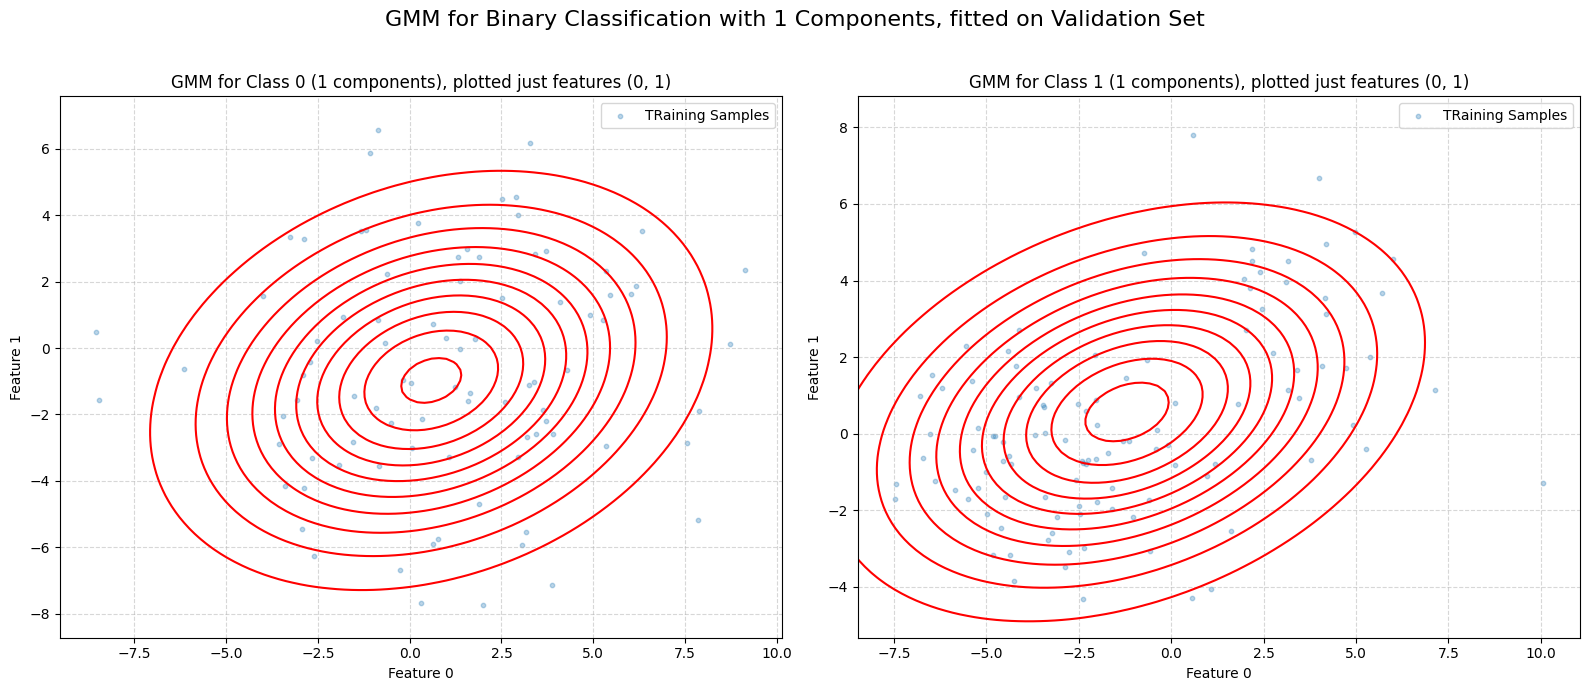

In [ ]:
#as before, we try different number of components, so we can see how the GMM performs with different number of components
k_data = []
minDCFs = []
DCF_data = []

for k in [1, 2, 4, 8, 16]:
    #compute llr
    gmm0, ll0 = train_GMM_EM_LBG(DTR[:, LTR == 0], targetNumberComponents=k, threshold_stop=1e-6, alpha=0.1, psiEig=0.01)
    gmm1, ll1 = train_GMM_EM_LBG(DTR[:, LTR == 1], targetNumberComponents=k, threshold_stop=1e-6, alpha=0.1, psiEig=0.01)

    plot_gmm_2d_classification(
         DVAL,
         LVAL,
         gmm0,
         gmm1,
         main_title=f"GMM for Binary Classification with {k} Components, fitted on Validation Set",
    )
    
    llr = logpdf_GMM(DVAL, gmm1) - logpdf_GMM(DVAL, gmm0)  #log likelihood ratio

    minDCF = computeMinEmpiricalBayesRisk_Normalized(llr, LVAL, 0.5, 1.0, 1.0)  #compute the normalized min DCF with a prior of 0.5
    DCF = computeEmpiricalBayesRisk_Normalized(llr, LVAL, 0.5, 1.0, 1.0)  #compute the normalized DCF with a prior of 0.5

    k_data.append(k)
    minDCFs.append(minDCF)
    DCF_data.append(DCF)


#plot in a table the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')
table_data = [["Number of components", "Min DCF", "DCF"]]
for k, minDCF, DCF in zip(k_data, minDCFs, DCF_data):
    table_data.append([k, f"{minDCF:.4f}", f"{DCF:.4f}"])

table = ax.table(cellText=table_data, colLabels=None, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(2, 2)
plt.title("GMM Performance on Binary Dataset", fontsize=16)
plt.show()






    